In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
# Step 1: Load the dataset
dataset = pd.read_csv('/content/drive/My Drive/telematics_syn.csv')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Create the adjusted ClaimYN label
dataset['ClaimYN'] = ((dataset['NB_Claim'] >= 1) & (dataset['AMT_Claim'] > 1000)).astype(int)

# Preprocess the dataset
# 1. Handle missing values
dataset.fillna(method='ffill', inplace=True)  # Simple forward fill for missing values

# 2. Encode categorical variables (if any exist)
categorical_columns = dataset.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])

# 3. Standardize numerical columns
numerical_columns = dataset.drop(columns=['ClaimYN', 'NB_Claim', 'AMT_Claim']).columns
scaler = StandardScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

# Handle the imbalance in the dataset using SMOTE
X = dataset.drop(columns=['ClaimYN'])
y = dataset['ClaimYN']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Merging resampled data back into a single DataFrame
dataset_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Drop NB_Claim and AMT_Claim columns
dataset_resampled = dataset_resampled.drop(columns=['NB_Claim', 'AMT_Claim'])

# Split the dataset into train, test, and validation sets
from sklearn.model_selection import train_test_split

X = dataset_resampled.drop(columns=['ClaimYN'])
y = dataset_resampled['ClaimYN']

# Split the data (70% train, 15% test, 15% validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 136222
Testing set size: 29191
Validation set size: 29191


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=200)
log_reg.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     14593
           1       0.74      0.80      0.77     14598

    accuracy                           0.76     29191
   macro avg       0.76      0.76      0.76     29191
weighted avg       0.76      0.76      0.76     29191



In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14593
           1       1.00      0.98      0.99     14598

    accuracy                           0.99     29191
   macro avg       0.99      0.99      0.99     29191
weighted avg       0.99      0.99      0.99     29191



In [7]:
from xgboost import XGBClassifier

# Initialize and train the XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14593
           1       1.00      0.98      0.99     14598

    accuracy                           0.99     29191
   macro avg       0.99      0.99      0.99     29191
weighted avg       0.99      0.99      0.99     29191



In [8]:
!pip install pytorch_tabnet

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [9]:
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np

# Convert data to numpy arrays for TabNet
X_train_np, y_train_np = X_train.values, y_train.values
X_test_np, y_test_np = X_test.values, y_test.values

# Initialize and train the TabNet model
tabnet = TabNetClassifier(seed=42)
tabnet.fit(X_train_np, y_train_np, eval_set=[(X_test_np, y_test_np)], patience=10)

# Evaluate the model on the test set
y_pred = np.argmax(tabnet.predict_proba(X_test_np), axis=1)
print("TabNet Classification Report:")
print(classification_report(y_test_np, y_pred))

epoch 0  | loss: 0.52451 | val_0_auc: 0.87515 |  0:00:20s
epoch 1  | loss: 0.43317 | val_0_auc: 0.89764 |  0:00:28s
epoch 2  | loss: 0.39164 | val_0_auc: 0.92828 |  0:00:35s
epoch 3  | loss: 0.34    | val_0_auc: 0.94508 |  0:00:41s
epoch 4  | loss: 0.31046 | val_0_auc: 0.95073 |  0:00:47s
epoch 5  | loss: 0.28787 | val_0_auc: 0.96103 |  0:00:54s
epoch 6  | loss: 0.27042 | val_0_auc: 0.962   |  0:01:00s
epoch 7  | loss: 0.26094 | val_0_auc: 0.96252 |  0:01:07s
epoch 8  | loss: 0.25302 | val_0_auc: 0.96613 |  0:01:13s
epoch 9  | loss: 0.24544 | val_0_auc: 0.96825 |  0:01:20s
epoch 10 | loss: 0.23994 | val_0_auc: 0.97131 |  0:01:28s
epoch 11 | loss: 0.23557 | val_0_auc: 0.96242 |  0:01:34s
epoch 12 | loss: 0.22619 | val_0_auc: 0.96915 |  0:01:40s
epoch 13 | loss: 0.22559 | val_0_auc: 0.96316 |  0:01:47s
epoch 14 | loss: 0.21921 | val_0_auc: 0.97498 |  0:01:53s
epoch 15 | loss: 0.21526 | val_0_auc: 0.9745  |  0:02:00s
epoch 16 | loss: 0.21137 | val_0_auc: 0.97374 |  0:02:05s
epoch 17 | los

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam

# Reshape data for RNN (3D input: samples, timesteps, features)
X_train_rnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_rnn = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_rnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Initialize the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, input_shape=(X_train_rnn.shape[1], 1), activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = rnn_model.evaluate(X_test_rnn, y_test)
print(f"RNN Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.7165 - loss: 0.5500 - val_accuracy: 0.7772 - val_loss: 0.4592
Epoch 2/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 68s 9ms/step - accuracy: 0.7839 - loss: 0.4654 - val_accuracy: 0.8045 - val_loss: 0.4255
Epoch 3/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.7879 - loss: 0.4588 - val_accuracy: 0.8167 - val_loss: 0.3953
Epoch 4/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.7816 - loss: 0.4563 - val_accuracy: 0.8140 - val_loss: 0.4056
Epoch 5/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.8164 - loss: 0.4062 - val_accuracy: 0.8453 - val_loss: 0.3407
Epoch 6/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.8421 - loss: 0.3535 - val_accuracy: 0.8292 - val_loss: 0.3974
Epoch 7/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.8597 - loss: 0.3170 - val_accuracy: 0.8717 - val_loss: 0.2947
Epoch 8/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.8697 - loss: 

In [11]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Initialize the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_rnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test_rnn, y_test)
print(f"CNN Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8094 - loss: 0.4178 - val_accuracy: 0.8509 - val_loss: 0.3311
Epoch 2/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8604 - loss: 0.3172 - val_accuracy: 0.8645 - val_loss: 0.3042
Epoch 3/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8691 - loss: 0.2989 - val_accuracy: 0.8709 - val_loss: 0.2944
Epoch 4/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8727 - loss: 0.2922 - val_accuracy: 0.8753 - val_loss: 0.2846
Epoch 5/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8774 - loss: 0.2808 - val_accuracy: 0.8784 - val_loss: 0.2777
Epoch 6/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8792 - loss: 0.2757 - val_accuracy: 0.8811 - val_loss: 0.2678
Epoch 7/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8843 - loss: 0.2674 - val_accuracy: 0.8840 - val_loss: 0.2625
Epoch 8/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8870 - loss: 0.2

In [12]:
from keras.layers import LSTM

# Initialize the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(X_train_rnn.shape[1], 1), activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32,
                              validation_data=(X_val_rnn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = lstm_model.evaluate(X_test_rnn, y_test)
print(f"LSTM Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.6933 - loss: 2.2730 - val_accuracy: 0.7259 - val_loss: 0.5484
Epoch 2/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.7570 - loss: 0.5071 - val_accuracy: 0.7922 - val_loss: 0.4492
Epoch 3/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.7875 - loss: 0.4906 - val_accuracy: 0.5996 - val_loss: 0.6645
Epoch 4/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.6468 - loss: 0.6309 - val_accuracy: 0.7484 - val_loss: 0.5099
Epoch 5/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.7626 - loss: 0.4924 - val_accuracy: 0.7833 - val_loss: 0.4575
Epoch 6/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.7861 - loss: 0.4598 - val_accuracy: 0.7947 - val_loss: 0.4436
Epoch 7/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.7064 - loss: 5092.8994 - val_accuracy: 0.5666 - val_loss: 2.1724
Epoch 8/50
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.5687 - loss

In [26]:
from keras.layers import GRU

# Initialize the GRU model
gru_model = Sequential()
gru_model.add(GRU(32, input_shape=(X_train_rnn.shape[1], 1), activation='relu'))
gru_model.add(Dense(1, activation='sigmoid'))

# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
gru_history = gru_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = gru_model.evaluate(X_test_rnn, y_test)
print(f"GRU Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.7164 - loss: 0.5378 - val_accuracy: 0.8182 - val_loss: 0.3920
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.8263 - loss: 0.3684 - val_accuracy: 0.8572 - val_loss: 0.3075
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8671 - loss: 0.2860 - val_accuracy: 0.8801 - val_loss: 0.2585
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.8800 - loss: 0.2610 - val_accuracy: 0.8923 - val_loss: 0.2426
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8907 - loss: 0.2445 - val_accuracy: 0.8862 - val_loss: 0.2445
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8926 - loss: 0.2358 - val_accuracy: 0.9034 - val_loss: 0.2212
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8986 - loss: 0.2267 - val_accuracy: 0.8970 - val_loss: 0.2253
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9022 - loss: 0

## Import Necessary Libraries for Evaluation

In [14]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have seaborn for nicer plots
sns.set(style="whitegrid")

In [15]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Evaluate the model using MCC, AUC, and plot the confusion matrix."""

    # Calculate MCC
    mcc = matthews_corrcoef(y_true, y_pred)

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred_proba)

    # Print results
    print(f"{model_name} Evaluation:")
    print(f"  MCC: {mcc:.4f}")
    print(f"  AUC: {auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

def plot_training_history(history, model_name):
    """Plot training & validation accuracy and loss from the model's history."""
    # Accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Logistic Regression Evaluation:
  MCC: 0.5272
  AUC: 0.8307


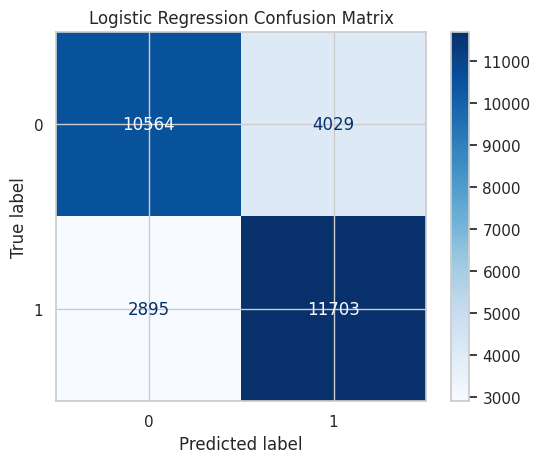

In [16]:
# Predict probabilities for AUC calculation
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the Logistic Regression model
evaluate_model(y_test, y_pred_log_reg, y_pred_proba_log_reg, "Logistic Regression")

Random Forest Evaluation:
  MCC: 0.9810
  AUC: 0.9987


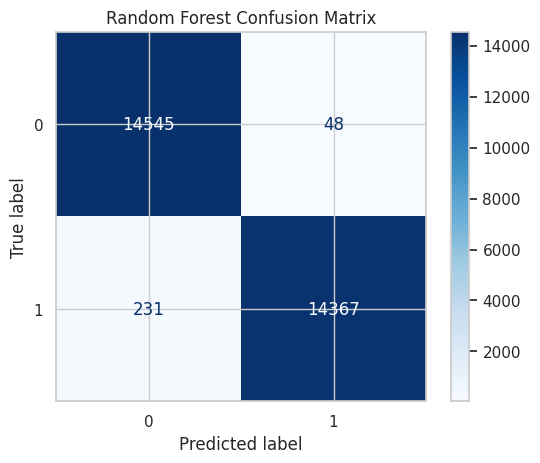

In [17]:
# Predict probabilities for AUC calculation
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

# Evaluate the Random Forest model
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest")

XGBoost Evaluation:
  MCC: 0.9771
  AUC: 0.9979


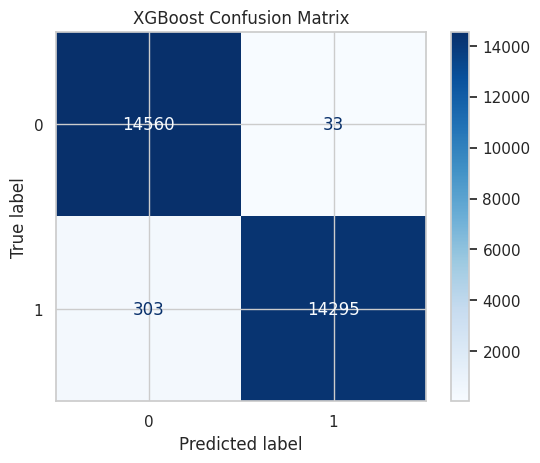

In [18]:
# Predict probabilities for AUC calculation
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb.predict(X_test)

# Evaluate the XGBoost model
evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

TabNet Evaluation:
  MCC: 0.7789
  AUC: 0.9778


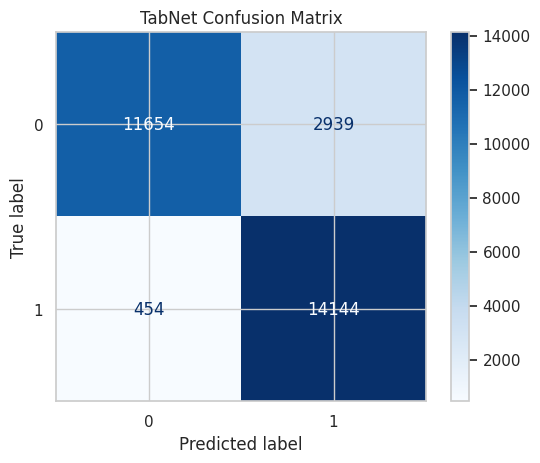

In [19]:
# Predict probabilities for AUC calculation
y_pred_proba_tabnet = tabnet.predict_proba(X_test_np)[:, 1]
y_pred_tabnet = np.argmax(tabnet.predict_proba(X_test_np), axis=1)

# Evaluate the TabNet model
evaluate_model(y_test_np, y_pred_tabnet, y_pred_proba_tabnet, "TabNet")

913/913 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
RNN Evaluation:
  MCC: 0.6814
  AUC: 0.9281


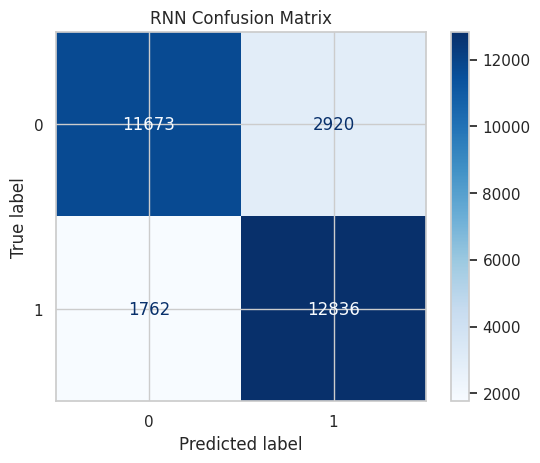

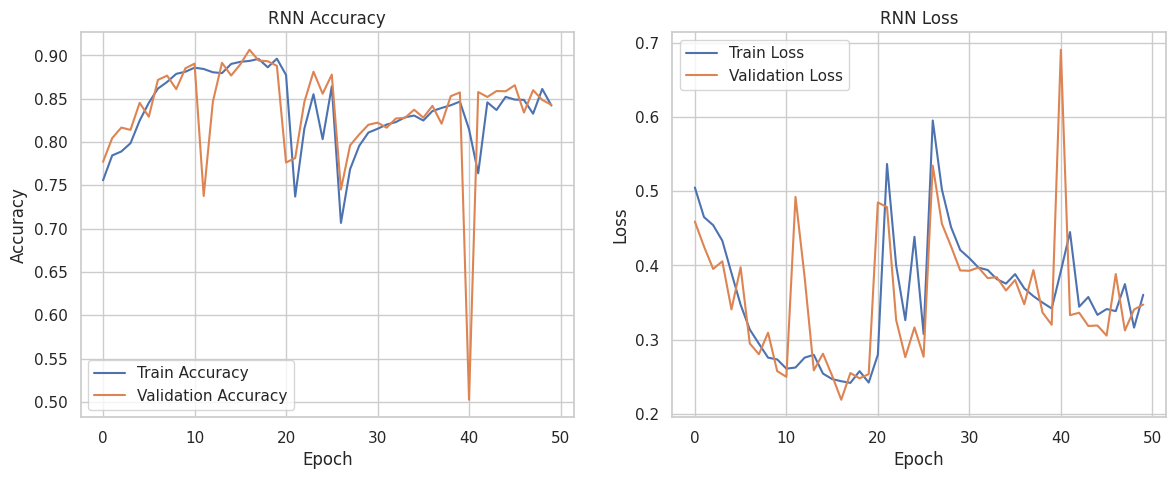

In [20]:
# Evaluate the RNN model
y_pred_proba_rnn = rnn_model.predict(X_test_rnn).flatten()
y_pred_rnn = (y_pred_proba_rnn > 0.5).astype(int)

evaluate_model(y_test, y_pred_rnn, y_pred_proba_rnn, "RNN")
plot_training_history(rnn_history, "RNN")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - accuracy: 0.8549 - loss: 0.3161 - val_accuracy: 0.8180 - val_loss: 0.3923
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.8546 - loss: 0.3215 - val_accuracy: 0.5340 - val_loss: 0.6912
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.5470 - loss: 0.6889 - val_accuracy: 0.5907 - val_loss: 0.6833
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.6463 - loss: 0.6243 - val_accuracy: 0.8069 - val_loss: 0.4329
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.8202 - loss: 0.3977 - val_accuracy: 0.8586 - val_loss: 0.3368
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.8504 - loss: 0.3359 - val_accuracy: 0.8566 - val_loss: 0.3266
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.8545 - loss: 0.3233 - val_accuracy: 0.8666 - val_loss: 0.2813
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8660 - loss: 

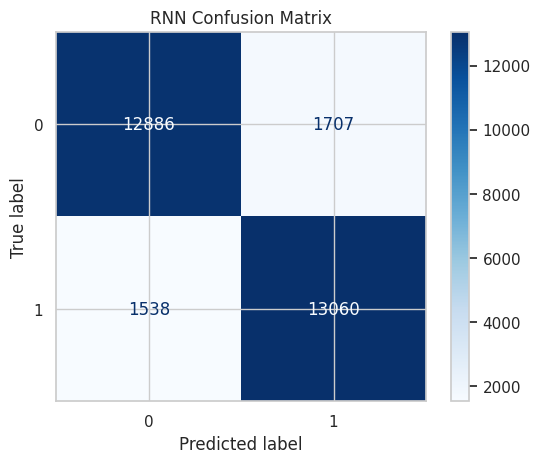

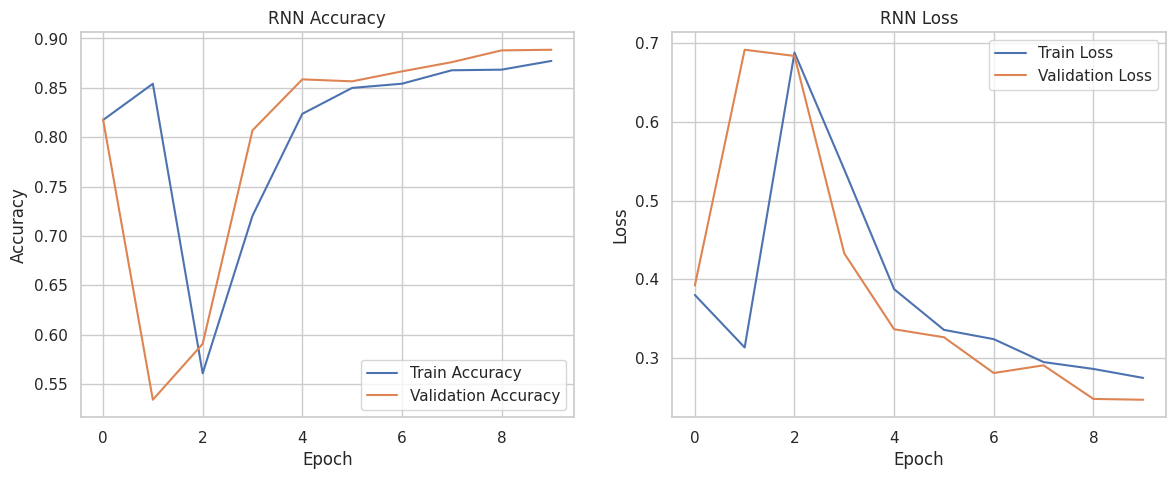

In [22]:
# Train the RNN model
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Predict on test set
y_pred_proba_rnn = rnn_model.predict(X_test_rnn).flatten()
y_pred_rnn = (y_pred_proba_rnn > 0.5).astype(int)

# Evaluate RNN model
evaluate_model(y_test, y_pred_rnn, y_pred_proba_rnn, "RNN")

# Plot training and validation history
plot_training_history(rnn_history, "RNN")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9174 - loss: 0.1966 - val_accuracy: 0.9187 - val_loss: 0.1949
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9168 - loss: 0.1974 - val_accuracy: 0.8949 - val_loss: 0.2324
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9197 - loss: 0.1950 - val_accuracy: 0.9187 - val_loss: 0.1980
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9188 - loss: 0.1925 - val_accuracy: 0.9185 - val_loss: 0.1935
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9185 - loss: 0.1934 - val_accuracy: 0.9159 - val_loss: 0.2059
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9189 - loss: 0.1924 - val_accuracy: 0.9196 - val_loss: 0.1915
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9198 - loss: 0.1922 - val_accuracy: 0.9198 - val_loss: 0.1920
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9202 - loss: 0.1899

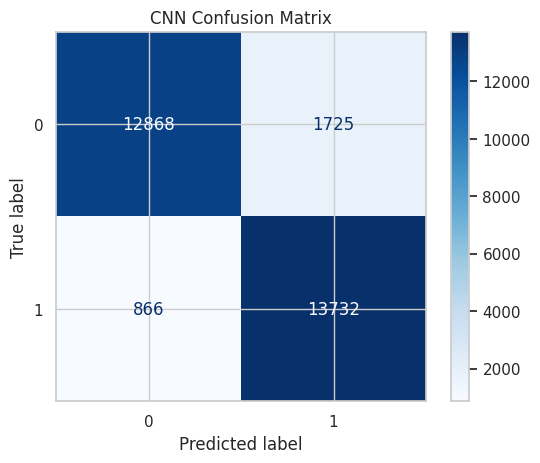

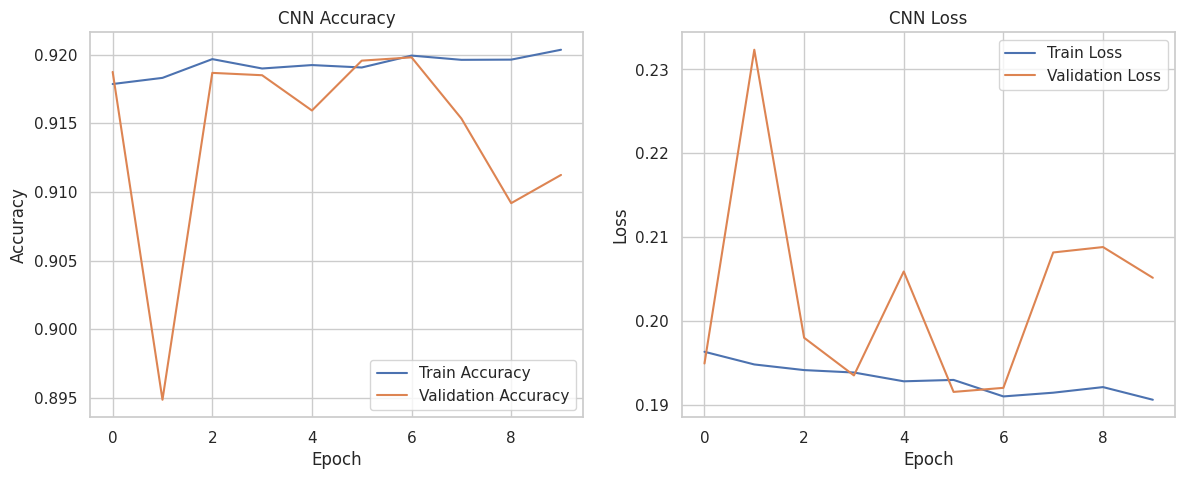

In [23]:
# Train the CNN model
cnn_history = cnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Predict on test set
y_pred_proba_cnn = cnn_model.predict(X_test_rnn).flatten()
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

# Evaluate CNN model
evaluate_model(y_test, y_pred_cnn, y_pred_proba_cnn, "CNN")

# Plot training and validation history
plot_training_history(cnn_history, "CNN")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.5756 - loss: 3071.3044 - val_accuracy: 0.5577 - val_loss: 24207.1543
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.5489 - loss: 7595.0117 - val_accuracy: 0.6029 - val_loss: 2222.9797
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.5439 - loss: 1345.8951 - val_accuracy: 0.5467 - val_loss: 197099.2188
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.5644 - loss: 33980.4492 - val_accuracy: 0.5135 - val_loss: 780.2173
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.5038 - loss: 9045.1514 - val_accuracy: 0.4505 - val_loss: 4.2048
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.4538 - loss: 4.6038 - val_accuracy: 0.5679 - val_loss: 11.4565
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.5713 - loss: 9.2296 - val_accuracy: 0.5642 - val_loss: 8.4402
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/st

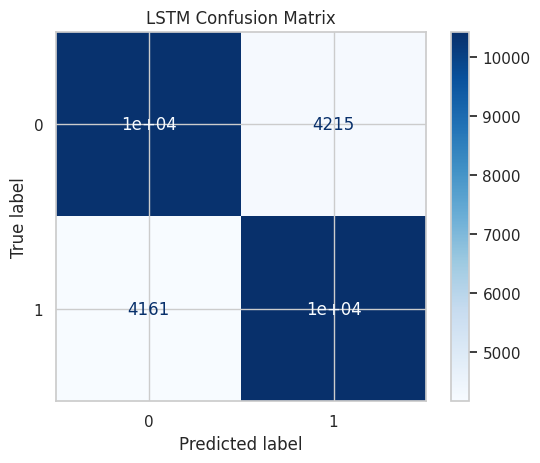

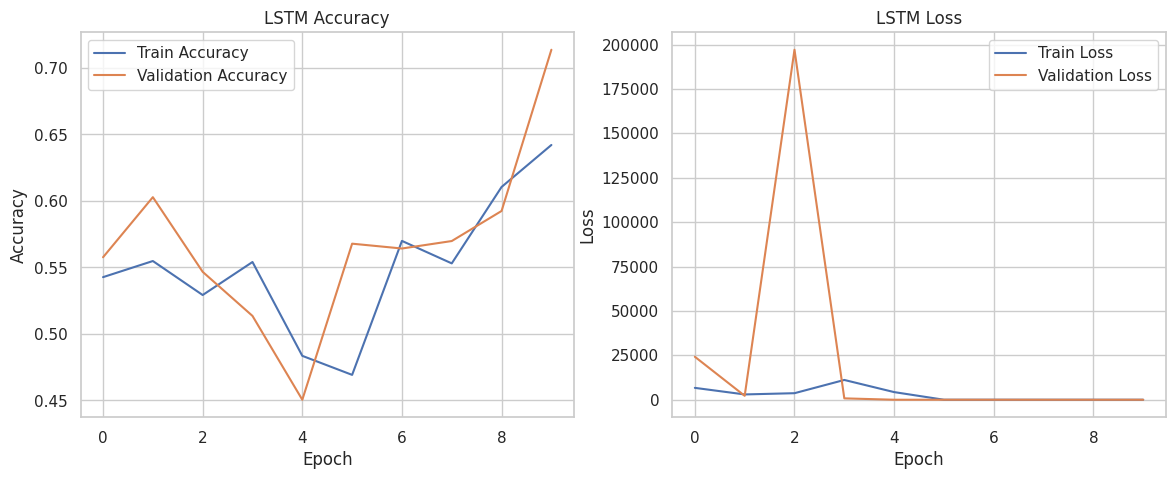

In [24]:
# Train the LSTM model
lstm_history = lstm_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                              validation_data=(X_val_rnn, y_val), verbose=1)

# Predict on test set
y_pred_proba_lstm = lstm_model.predict(X_test_rnn).flatten()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

# Evaluate LSTM model
evaluate_model(y_test, y_pred_lstm, y_pred_proba_lstm, "LSTM")

# Plot training and validation history
plot_training_history(lstm_history, "LSTM")

Epoch 1/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.9071 - loss: 0.2087 - val_accuracy: 0.9063 - val_loss: 0.2054
Epoch 2/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9091 - loss: 0.2065 - val_accuracy: 0.9100 - val_loss: 0.1984
Epoch 3/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.9119 - loss: 0.1991 - val_accuracy: 0.9107 - val_loss: 0.1967
Epoch 4/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9126 - loss: 0.1960 - val_accuracy: 0.8997 - val_loss: 0.2272
Epoch 5/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9130 - loss: 0.1971 - val_accuracy: 0.9116 - val_loss: 0.1963
Epoch 6/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9149 - loss: 0.1928 - val_accuracy: 0.9136 - val_loss: 0.1964
Epoch 7/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9167 - loss: 0.1869 - val_accuracy: 0.9143 - val_loss: 0.1891
Epoch 8/10
4257/4257 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.9176 - loss: 0

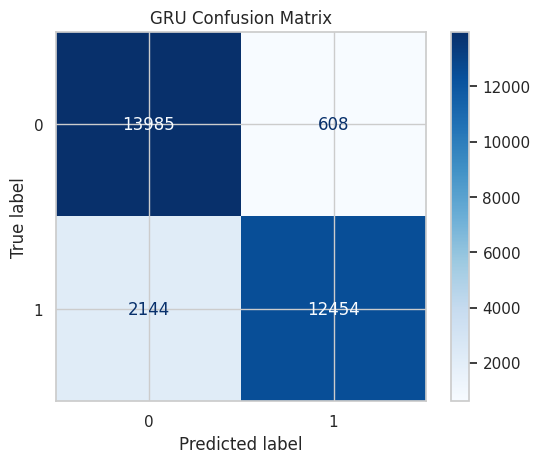

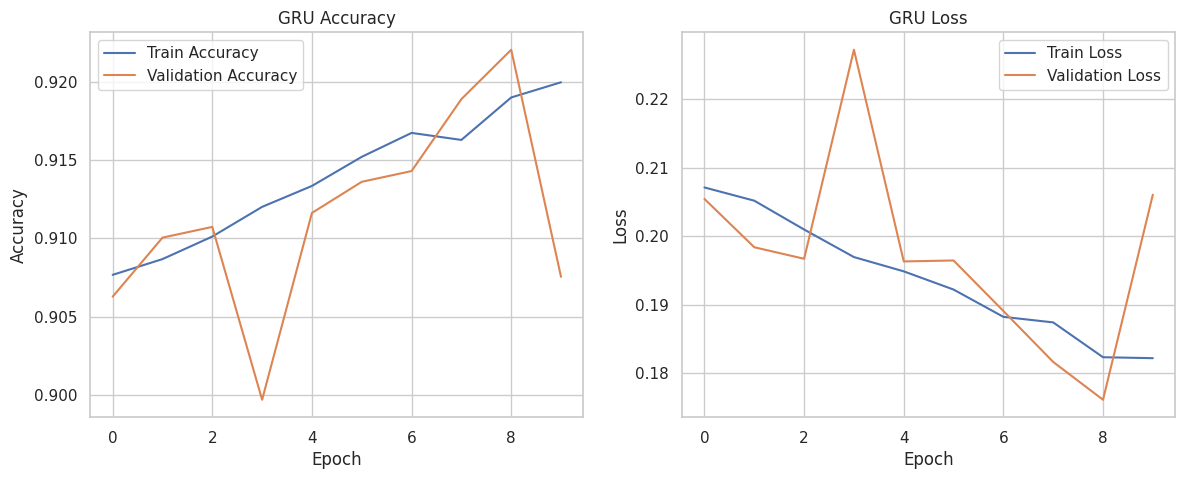

In [27]:
# Train the GRU model
gru_history = gru_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val_rnn, y_val), verbose=1)

# Predict on test set
y_pred_proba_gru = gru_model.predict(X_test_rnn).flatten()
y_pred_gru = (y_pred_proba_gru > 0.5).astype(int)

# Evaluate GRU model
evaluate_model(y_test, y_pred_gru, y_pred_proba_gru, "GRU")

# Plot training and validation history
plot_training_history(gru_history, "GRU")
